In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
work_dir = "drive/My Drive/Training Records/"
impl_type = "ConvLSTM"
dataset = "CIFAR100.fine.New.FOIU6"

In [3]:

import numpy as np
import pandas as pd
import pickle
import numpy as np
import random
import time
import os
#os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import CSVLogger
import keras

In [4]:
list_categories_coarse = ['aquatic mammals', 'fish', 'flowers',	'food containers', 'fruit and vegetables', 'household electrical devices', 
                          'household furniture', 'insects',	'large carnivores',	'large man-made outdoor things', 'large natural outdoor scenes',
                          'large omnivores and herbivores',	'medium-sized mammals',	'non-insect invertebrates',	'people', 'reptiles', 'small mammals',
                          'trees', 'vehicles 1', 'vehicles 2']

list_categories = ['beaver', 'dolphin', 'otter', 'seal', 'whale',
                   'aquarium fish', 'flatfish', 'ray', 'shark', 'trout',
                   'orchids', 'poppies', 'roses', 'sunflowers', 'tulips',
                   'bottles', 'bowls', 'cans', 'cups', 'plates',
                   'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers',
                   'clock', 'computer keyboard', 'lamp', 'telephone', 'television',
                   'bed', 'chair', 'couch', 'table', 'wardrobe',
                   'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',
                   'bear', 'leopard', 'lion', 'tiger', 'wolf',
                   'bridge', 'castle', 'house', 'road', 'skyscraper',
                   'cloud', 'forest', 'mountain', 'plain', 'sea',
                   'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',
                   'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
                   'crab', 'lobster', 'snail', 'spider', 'worm',
                   'baby', 'boy', 'girl', 'man', 'woman',
                   'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',
                   'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
                   'maple', 'oak', 'palm', 'pine', 'willow',
                   'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train',
                   'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']
                   
num_classes = len(list_categories)
print('num_classes =', num_classes)

num_classes = 100


In [5]:
# CIFAR100: Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass 
# to which it belongs):
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

print('x_train.shape =',x_train.shape)
print('y_train.shape =',y_train.shape)
print('x_test.shape =',x_test.shape)
print('y_test.shape =',y_test.shape)

169009152/169001437 [==============================] - 2s 0us/step
x_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 1)
x_test.shape = (10000, 32, 32, 3)
y_test.shape = (10000, 1)


In [6]:
'''
x_train_norm_rgb = x_train/255 
x_test_norm_rgb = x_test/255
#'''

'\nx_train_norm_rgb = x_train/255 \nx_test_norm_rgb = x_test/255\n#'

In [7]:
'''
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(0.2989, dtype=dtype), np.asarray(0.5870, dtype=dtype), np.asarray(0.1140, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    #rst = np.expand_dims(rst, axis=3)
    return rst
#'''

"\ndef grayscale(data, dtype='float32'):\n    # luma coding weighted average in video systems\n    r, g, b = np.asarray(0.2989, dtype=dtype), np.asarray(0.5870, dtype=dtype), np.asarray(0.1140, dtype=dtype)\n    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]\n    # add channel dimension\n    #rst = np.expand_dims(rst, axis=3)\n    return rst\n#"

In [8]:
'''
x_train_norm = grayscale(x_train_norm_rgb)
x_test_norm = grayscale(x_test_norm_rgb)

print('x_train_norm.shape =',x_train_norm.shape)
print('x_test_norm.shape =',x_test_norm.shape)
#'''

"\nx_train_norm = grayscale(x_train_norm_rgb)\nx_test_norm = grayscale(x_test_norm_rgb)\n\nprint('x_train_norm.shape =',x_train_norm.shape)\nprint('x_test_norm.shape =',x_test_norm.shape)\n#"

In [9]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    #r, g, b = np.asarray(0.2989, dtype=dtype), np.asarray(0.5870, dtype=dtype), np.asarray(0.1140, dtype=dtype)
    #rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    #rst = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
    # add channel dimension
    #rst = np.expand_dims(rst, axis=3)
    r = data[:, :, :, 0] 
    g = data[:, :, :, 1] 
    b = data[:, :, :, 2]
    return r/255, g/255, b/255 #np.array([r,g,b])

In [10]:
x_train_norm_r, x_train_norm_g, x_train_norm_b = grayscale(x_train)
x_test_norm_r, x_test_norm_g, x_test_norm_b = grayscale(x_test)

print('x_train_norm_r.shape =',x_train_norm_r.shape)
print('x_test_norm_r.shape =',x_test_norm_r.shape)

x_train_norm_r.shape = (50000, 32, 32)
x_test_norm_r.shape = (10000, 32, 32)


In [11]:
final_train_imageset_r = np.expand_dims(x_train_norm_r, axis = 3)
final_test_imageset_r = np.expand_dims(x_test_norm_r, axis = 3)

final_train_imageset_g = np.expand_dims(x_train_norm_g, axis = 3)
final_test_imageset_g = np.expand_dims(x_test_norm_g, axis = 3)

final_train_imageset_b = np.expand_dims(x_train_norm_b, axis = 3)
final_test_imageset_b = np.expand_dims(x_test_norm_b, axis = 3)

#y_train2 = np.expand_dims(y_train, axis = 1)
#y_test2 = np.expand_dims(y_test, axis = 1)

print('final_train_imageset_r.shape =', final_train_imageset_r.shape)
print('final_test_imageset_r.shape =', final_test_imageset_r.shape)
#print('y_train2.shape =', y_train2.shape)
#print('y_test2.shape =', y_test2.shape)

final_train_imageset_r.shape = (50000, 32, 32, 1)
final_test_imageset_r.shape = (10000, 32, 32, 1)


In [12]:
final_train_label = tf.keras.utils.to_categorical(y_train, num_classes)
final_test_label = tf.keras.utils.to_categorical(y_test, num_classes)

print('final_train_label.shape =',final_train_label.shape)
print('final_test_label.shape =',final_test_label.shape)

final_train_label.shape = (50000, 100)
final_test_label.shape = (10000, 100)


In [35]:
NUM_NEURONS = 16
NUM_LAYERS = 3
BATCH_SIZE = 10
NUM_EPOCHS = 300
epochs_completed = 0
LEARNING_RATE = 0.0001
EPSILON = 1e-4
DROPOUT = 0.5

LOSS = 'categorical_crossentropy'
ACTIVATION_FUNCTION = 'relu'
FINAL_ACTIVATION_FUNCTION = 'softmax'
validation_split = 0.1
kernel_size=(1,1)

nTry = "5"
# +"_kernel"+str(kernel_size)+"_lr"+str(LEARNING_RATE)+"_batch"+str(BATCH_SIZE)+"_epochs"+str(NUM_EPOCHS)
#checkpointer_name  = "weights_"+dataset+"_"+impl_type+"_nLayers"+str(NUM_LAYERS)+"_nNeurons"+str(NUM_NEURONS)+"_dropout"+str(DROPOUT)+"_batch"+str(BATCH_SIZE)+".hdf5"
checkpointer_name  = "weights."+dataset+"."+impl_type+".batch"+str(BATCH_SIZE)+".nTry."+nTry
log_name = "log."+checkpointer_name[8:]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)

checkpointer_name = weights.CIFAR100.fine.New.FOIU6.ConvLSTM.batch10.nTry.5
log_name = log.CIFAR100.fine.New.FOIU6.ConvLSTM.batch10.nTry.5.log


In [36]:
final_train_imageset_r.shape[1:]

(32, 32, 1)

In [37]:
input_shape = (final_train_imageset_r.shape[1:], final_train_imageset_g.shape[1:], final_train_imageset_b.shape[1:])
input_shape

((32, 32, 1), (32, 32, 1), (32, 32, 1))

In [38]:
#'''
input_shape = (final_train_imageset_r.shape[1:], final_train_imageset_g.shape[1:], final_train_imageset_b.shape[1:])

#####
inputs_r = Input(input_shape[0])
x_r = inputs_r

up_size = 2
x_r = UpSampling2D(size=(up_size, up_size))(x_r)
x_r = Conv2D(32, (3,3), activation='relu')(x_r)
x_r = MaxPool2D(pool_size=(2, 2))(x_r)
x_r = Dropout(DROPOUT)(x_r)

up_size = 2
x_r = UpSampling2D(size=(up_size, up_size))(x_r)
x_r = Conv2D(32, (3,3), activation='relu')(x_r)
x_r = MaxPool2D(pool_size=(2, 2))(x_r)
x_r = Dropout(DROPOUT)(x_r)

up_size = 2
x_r = UpSampling2D(size=(up_size, up_size))(x_r)
x_r = Conv2D(32, (3,3), activation='relu')(x_r)
x_r = MaxPool2D(pool_size=(2, 2))(x_r)
x_r = Dropout(DROPOUT)(x_r)

x_r = Flatten()(x_r)
#x_r = Dense(512, activation='relu')(x_r)
o_r = Dense(num_classes, activation='sigmoid')(x_r)
#####

inputs_g = Input(input_shape[1])
x_g = inputs_g

up_size = 2
x_g = UpSampling2D(size=(up_size, up_size))(x_g)
x_g = Conv2D(32, (3,3), activation='relu')(x_g)
x_g = MaxPool2D(pool_size=(2, 2))(x_g)
x_g = Dropout(DROPOUT)(x_g)

up_size = 2
x_g = UpSampling2D(size=(up_size, up_size))(x_g)
x_g = Conv2D(32, (3,3), activation='relu')(x_g)
x_g = MaxPool2D(pool_size=(2, 2))(x_g)
x_g = Dropout(DROPOUT)(x_g)

up_size = 2
x_g = UpSampling2D(size=(up_size, up_size))(x_g)
x_g = Conv2D(32, (3,3), activation='relu')(x_g)
x_g = MaxPool2D(pool_size=(2, 2))(x_g)
x_g = Dropout(DROPOUT)(x_g)

x_g = Flatten()(x_g)
#x_g = Dense(512, activation='relu')(x_g)
o_g = Dense(num_classes, activation='sigmoid')(x_g)
#####

inputs_b = Input(input_shape[2])
x_b = inputs_b

up_size = 2
x_b = UpSampling2D(size=(up_size, up_size))(x_b)
x_b = Conv2D(32, (3,3), activation='relu')(x_b)
x_b = MaxPool2D(pool_size=(2, 2))(x_b)
x_b = Dropout(DROPOUT)(x_b)

up_size = 2
x_b = UpSampling2D(size=(up_size, up_size))(x_b)
x_b = Conv2D(32, (3,3), activation='relu')(x_b)
x_b = MaxPool2D(pool_size=(2, 2))(x_b)
x_b = Dropout(DROPOUT)(x_b)

up_size = 2
x_b = UpSampling2D(size=(up_size, up_size))(x_b)
x_b = Conv2D(32, (3,3), activation='relu')(x_b)
x_b = MaxPool2D(pool_size=(2, 2))(x_b)
x_b = Dropout(DROPOUT)(x_b)

x_b = Flatten()(x_b)
#x_b = Dense(512, activation='relu')(x_b)
o_b = Dense(num_classes, activation='sigmoid')(x_b)
#####

add_rg = Add()([x_r, x_g])
add_gb = Add()([x_g, x_b])
add_br = Add()([x_b, x_r])
#####

add_all = Add()([add_rg, add_gb, add_br])
outputs = Dense(num_classes, activation=FINAL_ACTIVATION_FUNCTION)(add_all)

model = Model(inputs=(inputs_r, inputs_g, inputs_b), outputs=outputs)
model.summary()
#'''

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
up_sampling2d_12 (UpSampling2D) (None, 64, 64, 1)    0           input_7[0][0]                    
____________________________________________________________________________________________

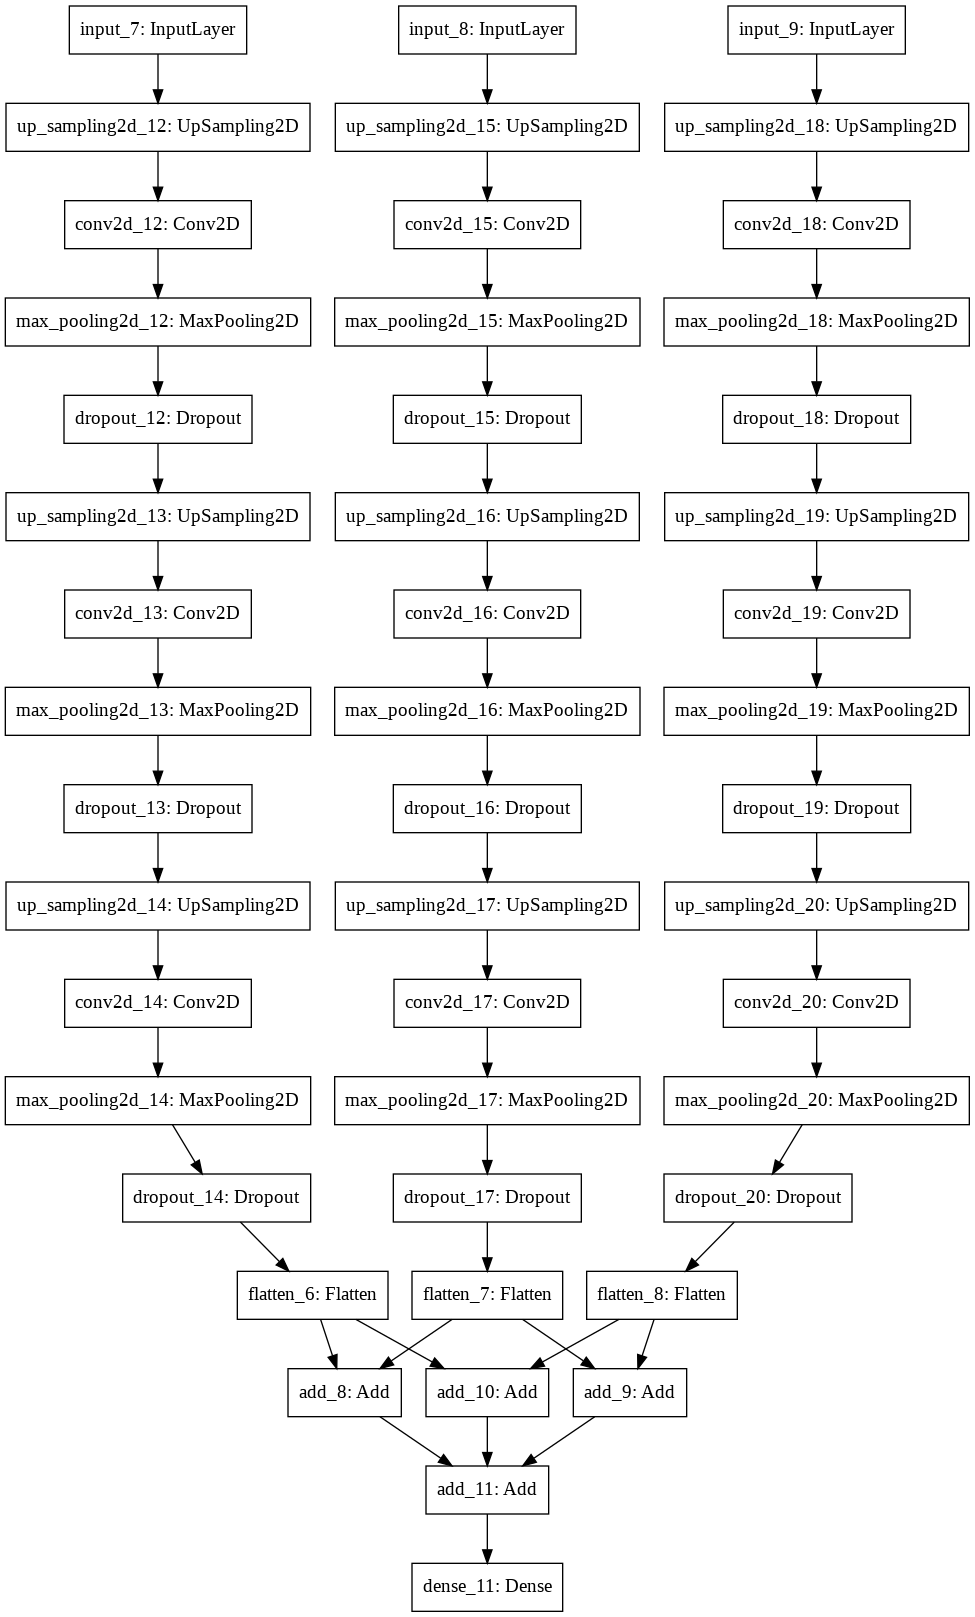

In [39]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [40]:
'''
model = keras.Sequential(
    [
        keras.Input(
            shape=(None, 32, 32, 1)
        ),  # Variable-length sequence of 40x40x1 frames
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)
model.summary()
#'''

'\nmodel = keras.Sequential(\n    [\n        keras.Input(\n            shape=(None, 32, 32, 1)\n        ),  # Variable-length sequence of 40x40x1 frames\n        layers.ConvLSTM2D(\n            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True\n        ),\n        layers.BatchNormalization(),\n        layers.ConvLSTM2D(\n            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True\n        ),\n        layers.BatchNormalization(),\n        layers.ConvLSTM2D(\n            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True\n        ),\n        layers.BatchNormalization(),\n        layers.ConvLSTM2D(\n            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True\n        ),\n        layers.BatchNormalization(),\n        layers.Conv3D(\n            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"\n        ),\n    ]\n)\nmodel.summary()\n#'

In [41]:
optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)
model.compile(
    optimizer=optimizer, #'rmsprop',
    loss=LOSS,
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [42]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = work_dir+checkpointer_name, verbose = 1, save_best_only = True)

In [43]:
if epochs_completed > 0:
    model = load_model(work_dir+checkpointer_name)
    print("Loaded partially trained model...")

In [44]:
tf.config.run_functions_eagerly(True)

In [ ]:
print('checkpointer_name =', checkpointer_name)
print("Previously completed epochs =", epochs_completed, "\n")
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)

start_time = time.time()
history = model.fit((final_train_imageset_r, final_train_imageset_g, final_train_imageset_b), 
                    final_train_label, 
                    shuffle=True, 
                    batch_size = BATCH_SIZE, 
                    epochs = NUM_EPOCHS - epochs_completed, 
                    #steps_per_epoch = 2,
                    #validation_split = validation_split, 
                    validation_data = ((final_test_imageset_r, final_test_imageset_g, final_test_imageset_b),
                                       final_test_label),
                    callbacks=[checkpointer, csv_logger]
                    )
elapsed_time = time.time() - start_time 
print("\nTime elapsed: ", elapsed_time)

checkpointer_name = weights.CIFAR100.fine.New.FOIU6.ConvLSTM.batch10.nTry.5
Previously completed epochs = 0 



/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/300
1154/5000 [=====>........................] - ETA: 3:07 - loss: 4.5233 - accuracy: 0.0401

In [ ]:
result = model.evaluate((final_test_imageset_r, final_test_imageset_g, final_test_imageset_b),
                                       final_test_label)
print("Accuracy : {}, Loss: {}".format(result[1], result[0]))

In [ ]:
model_loaded = load_model(work_dir+checkpointer_name)

In [ ]:
'''
Record:
Epochs = 050, Test Acc = 0., Test Loss = 0.;
Epochs = 100, Test Acc = 0., Test Loss = 0.;
#'''

result2 = model_loaded.evaluate((final_test_imageset_r, final_test_imageset_g, final_test_imageset_b),
                                       final_test_label)
print("Accuracy : {}, Loss: {}".format(result2[1], result2[0]))

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

In [ ]:
# Precision [TP/TP+FP] = The ratio of correctly predicted positive observations to the total predicted positive observations.
# Recall (Sensitivity) [TP/TP+FN] = The ratio of correctly predicted positive observations to the all observations in actual class - 'yes'.
# F1 score [F1 Score = 2*(Recall * Precision) / (Recall + Precision)] = The weighted average of Precision and Recall.
# Support = The number of samples of the true response that lie in that class.
print('Classification Report:')
#target_names = ['Mono', 'Di'] # not ['Di', 'Mono']
print(classification_report(y_test, y_pred)) #, target_names=target_names))

In [ ]:
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=list_categories))

In [ ]:
log_data = pd.read_csv(work_dir+log_name, sep=',', engine='python') 

In [ ]:
# Getting the model history keys 
#history.history.keys()
log_data.head()

In [ ]:
# plot the training artifacts

plt.plot(log_data['loss'])
plt.plot(log_data['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'best')
plt.show()

In [ ]:
plt.plot(log_data['accuracy'])
plt.plot(log_data['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'best')
plt.show()